**Environment Setup**

First, install all necessary libraries. Also use spacy for tokenization and other libraries for data handling and visualization.

In [17]:
# Install necessary libraries
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
!pip install spacy
!pip install tqdm seaborn
!python -m spacy download en_core_web_sm


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 108.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**Import Libraries**

Import all the required libraries for data processing, model building, training, and visualization.

In [18]:
import os
import torch
import random
import math
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm  # Progress bar
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import spacy
from collections import Counter

# Synonym Replacement Augmentation
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Set Seeds and Device**

Setting seeds ensures reproducibility of results. Check if a GPU is available for faster computation.

In [19]:
# Print PyTorch and CUDA information
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

# Set seeds for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


PyTorch Version: 2.5.1+cu121
CUDA Available: True
Number of GPUs: 1
GPU Name: NVIDIA A100-SXM4-40GB
Using device: cuda


**Prepare Dataset**

Use the pre-extracted dataset. They data is organized into CSV files with one sentence per line.

In [20]:
# Helper function to read a CSV file with one sentence per line
def read_csv_file(filepath, label, max_samples=None):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if max_samples and i >= max_samples:
                break
            text = line.strip()
            if text:
                data.append((label, text))
    return data

DATA_DIR = "/content"

# Specify the maximum number of samples per file (e.g., 5000)
MAX_SAMPLES = 10000
MAX_TEST_SAMPLES = 5000

# Read the CSV files
train_pos = read_csv_file(os.path.join(DATA_DIR, 'train_pos.csv'), label=1, max_samples=MAX_SAMPLES)
train_neg = read_csv_file(os.path.join(DATA_DIR, 'train_neg.csv'), label=0, max_samples=MAX_SAMPLES)
test_pos = read_csv_file(os.path.join(DATA_DIR, 'test_pos.csv'), label=1, max_samples=MAX_TEST_SAMPLES)
test_neg = read_csv_file(os.path.join(DATA_DIR, 'test_neg.csv'), label=0, max_samples=MAX_TEST_SAMPLES)

# Desired total number of training samples and ratio
TOTAL_TRAIN_SAMPLES = 10000
POS_RATIO = 0.3
NEG_RATIO = 1.0 - POS_RATIO

# Calculate how many positive and negative samples to use
num_pos = int(TOTAL_TRAIN_SAMPLES * POS_RATIO)
num_neg = TOTAL_TRAIN_SAMPLES - num_pos

# Ensure we do not exceed the available samples
num_pos = min(num_pos, len(train_pos))
num_neg = min(num_neg, len(train_neg))

if num_pos < int(TOTAL_TRAIN_SAMPLES * POS_RATIO):
    print("Warning: Not enough positive samples to meet the desired ratio. Using all available positives.")
if num_neg < int(TOTAL_TRAIN_SAMPLES * NEG_RATIO):
    print("Warning: Not enough negative samples to meet the desired ratio. Using all available negatives.")

random.shuffle(train_pos)
random.shuffle(train_neg)

train_data = train_pos[:num_pos] + train_neg[:num_neg]
random.shuffle(train_data)

test_data = test_pos + test_neg

print(f"Total chosen training samples: {len(train_data)} (Pos: {num_pos}, Neg: {num_neg})")
print(f"Total test samples: {len(test_data)}")

Total chosen training samples: 10000 (Pos: 3000, Neg: 7000)
Total test samples: 10000


**Tokenization and Vocabulary Building**

Tokenization splits sentences into words (tokens). Use spacy for efficient tokenization. After tokenizing, willbuild a vocabulary mapping each unique token to an integer index.

In [21]:
# Load spaCy English model
try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model loaded successfully.")
except OSError:
    print("spaCy model not found. Downloading 'en_core_web_sm'...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model loaded successfully after downloading.")

# Tokenization function
def tokenize(text, nlp):
    return [tok.text.lower() for tok in nlp(text)]

# Example tokenization
sample_text = "This is a fantastic movie! I loved every moment of it."
tokens = tokenize(sample_text, nlp)
print(f"Tokens: {tokens}")

# Build Vocabulary
texts = [text for label, text in train_data]

# Initialize Counter
counter = Counter()

# Tokenize all texts and update the counter
print("Building vocabulary...")
for doc in tqdm(nlp.pipe(texts, batch_size=1000, disable=["parser", "ner"]), total=len(texts), desc="Tokenizing"):
    tokens = [tok.text.lower() for tok in doc]
    counter.update(tokens)

# Keep top 25,000 words
most_common = counter.most_common(25000)
vocab_words = [word for word, freq in most_common]

# Add special tokens
special_tokens = ['<pad>', '<unk>']
stoi = {w: i + len(special_tokens) for i, w in enumerate(vocab_words)}
stoi['<pad>'] = 0
stoi['<unk>'] = 1
itos = {i: w for w, i in stoi.items()}

print(f"Vocabulary size: {len(stoi)}")


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


spaCy model loaded successfully.
Tokens: ['this', 'is', 'a', 'fantastic', 'movie', '!', 'i', 'loved', 'every', 'moment', 'of', 'it', '.']
Building vocabulary...


Tokenizing: 100%|██████████| 10000/10000 [00:18<00:00, 541.87it/s]

Vocabulary size: 18240


**Create PyTorch Dataset and DataLoader**

Create a custom Dataset class to handle our data and a DataLoader for batching. Padding ensures that all sequences in a batch have the same length.

In [22]:
# Define a custom Dataset
class IMDBDataset(Dataset):
    def __init__(self, data, stoi, nlp, max_length=None):
        self.data = data
        self.stoi = stoi
        self.nlp = nlp
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, text = self.data[idx]
        tokens = tokenize(text, self.nlp)
        numericalized = [self.stoi.get(t, self.stoi['<unk>']) for t in tokens]
        if self.max_length:
            numericalized = numericalized[:self.max_length]
        return torch.tensor(numericalized, dtype=torch.long), torch.tensor(label, dtype=torch.float)

# Define a Collate Function for DataLoader
class CollateFn:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        texts, labels = zip(*batch)
        lengths = torch.tensor([len(x) for x in texts], dtype=torch.long)
        padded_texts = pad_sequence(texts, batch_first=True, padding_value=self.pad_idx)
        return padded_texts, lengths, torch.tensor(labels, dtype=torch.float)

# Split training data into train and validation sets
random.shuffle(train_data)
split_ratio = 0.8
split_index = int(len(train_data) * split_ratio)
valid_data = train_data[split_index:]
train_data = train_data[:split_index]

print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(valid_data)}")
print(f"Test samples: {len(test_data)}")

# Create datasets
MAX_LENGTH = 256
train_dataset = IMDBDataset(train_data, stoi, nlp, max_length=MAX_LENGTH)
valid_dataset = IMDBDataset(valid_data, stoi, nlp, max_length=MAX_LENGTH)
test_dataset = IMDBDataset(test_data, stoi, nlp, max_length=MAX_LENGTH)

# Create DataLoaders
PAD_IDX = stoi['<pad>']
collate_fn_instance = CollateFn(pad_idx=PAD_IDX)

BATCH_SIZE = 128
NUM_WORKERS = 4
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn_instance,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn_instance,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn_instance,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("DataLoaders created.")


Train samples: 8000
Validation samples: 2000
Test samples: 10000
DataLoaders created.


**Define the Transformer Model**

Define a Transformer-based model with an embedding layer, positional encoding, a multi-layer Transformer encoder, dropout, and a fully connected layer for binary classification. The model leverages self-attention to capture relationships between tokens and applies average pooling for sequence representation.

In [23]:
# Positional Encoding to add positional information to token embeddings
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create a matrix of shape (max_len, d_model) where each row
        # is the positional encoding for a particular token position.
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)   # even positions
        pe[:, 1::2] = torch.cos(position * div_term)   # odd positions
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        # Add positional encodings
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_heads, num_encoder_layers, hidden_dim, output_dim, max_length, pad_idx, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout, max_len=max_length)

        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)

        # Classification head
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.fc.weight, mean=0, std=0.1)
        nn.init.constant_(self.fc.bias, 0)

    def forward(self, text, lengths):
        # text shape: (batch_size, seq_len)
        embedded = self.embedding(text)   # (batch_size, seq_len, embedding_dim)
        embedded = self.pos_encoder(embedded) # add positional encoding

        # Create a mask to avoid attention on padding tokens
        # Transformer expects masks in the form: True for tokens to mask
        # We'll create a mask where True = PAD token
        pad_mask = (text == PAD_IDX)
        # pad_mask shape: (batch_size, seq_len)

        # TransformerEncoder: (batch_size, seq_len, embedding_dim)
        encoder_output = self.transformer_encoder(embedded, src_key_padding_mask=pad_mask)

        # We can use the representation of the first token or an average pooling
        # Here, let's try average pooling over all non-pad tokens
        # mask out pad positions before pooling
        lengths = lengths.unsqueeze(1)  # shape: (batch_size, 1)
        mask = ~pad_mask  # True where not pad
        mask = mask.unsqueeze(-1).expand(encoder_output.size()) # (batch_size, seq_len, embedding_dim)

        # Sum over non-pad tokens
        sum_enc = (encoder_output * mask).sum(dim=1)  # (batch_size, embedding_dim)
        # Divide by the number of non-pad tokens to get average
        avg_enc = sum_enc / lengths  # (batch_size, embedding_dim)

        output = self.fc(self.dropout(avg_enc))  # (batch_size, output_dim)
        return output.squeeze(1)


**Training and Evaluation**

Define the training and evaluation functions. Use Binary Cross-Entropy loss with logits and the Adam optimizer. Also track accuracy during training.

In [24]:
# Initialize Model, Optimizer, Loss
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
N_HEADS = 4
NUM_ENCODER_LAYERS = 2


model = TransformerClassifier(
    vocab_size=len(stoi),
    embedding_dim=EMBEDDING_DIM,
    n_heads=N_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    max_length=MAX_LENGTH,
    pad_idx=PAD_IDX,
    dropout=DROPOUT
)

model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[stoi['<unk>']] = torch.zeros(EMBEDDING_DIM)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss().to(device)

def binary_accuracy(preds, y):
    probs = torch.sigmoid(preds)
    rounded = torch.round(probs)
    correct = (rounded == y).float()
    return correct.sum() / len(correct)

def train_fn(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for texts, lengths, labels in loader:
        texts, lengths, labels = texts.to(device), lengths.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts, lengths)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(loader), epoch_acc / len(loader)

def eval_fn(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for texts, lengths, labels in loader:
            texts, lengths, labels = texts.to(device), lengths.to(device), labels.to(device)
            predictions = model(texts, lengths)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(loader), epoch_acc / len(loader)

**Train the Model**

Train the model for a specified number of epochs, saving the best model based on validation loss.

In [25]:
# Train the Model
N_EPOCHS = 30
best_valid_loss = float('inf')

train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

for epoch in range(N_EPOCHS):
    print(f"Epoch: {epoch + 1}/{N_EPOCHS}")
    train_loss, train_acc = train_fn(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = eval_fn(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')
        print(f"  Best model saved (Validation Loss: {valid_loss:.4f})")

    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc * 100:.2f}%")
    print(f"  Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc * 100:.2f}%\n")


Epoch: 1/30
  Best model saved (Validation Loss: 0.6052)
  Train Loss: 0.6219 | Train Acc: 69.11%
  Valid Loss: 0.6052 | Valid Acc: 70.83%

Epoch: 2/30
  Best model saved (Validation Loss: 0.6016)
  Train Loss: 0.6118 | Train Acc: 69.72%
  Valid Loss: 0.6016 | Valid Acc: 70.83%

Epoch: 3/30
  Best model saved (Validation Loss: 0.5985)
  Train Loss: 0.6021 | Train Acc: 69.63%
  Valid Loss: 0.5985 | Valid Acc: 70.73%

Epoch: 4/30
  Train Loss: 0.5853 | Train Acc: 70.18%
  Valid Loss: 0.6036 | Valid Acc: 70.44%

Epoch: 5/30
  Train Loss: 0.5789 | Train Acc: 70.76%
  Valid Loss: 0.5996 | Valid Acc: 70.95%

Epoch: 6/30
  Train Loss: 0.5730 | Train Acc: 71.17%
  Valid Loss: 0.5999 | Valid Acc: 70.06%

Epoch: 7/30
  Train Loss: 0.5600 | Train Acc: 71.74%
  Valid Loss: 0.6027 | Valid Acc: 71.24%

Epoch: 8/30
  Train Loss: 0.5538 | Train Acc: 72.05%
  Valid Loss: 0.6151 | Valid Acc: 66.40%

Epoch: 9/30
  Train Loss: 0.5413 | Train Acc: 73.52%
  Valid Loss: 0.6095 | Valid Acc: 66.94%

Epoch: 10/

**Visualization**

Visualize the training and validation loss and accuracy over epochs using matplotlib and seaborn.

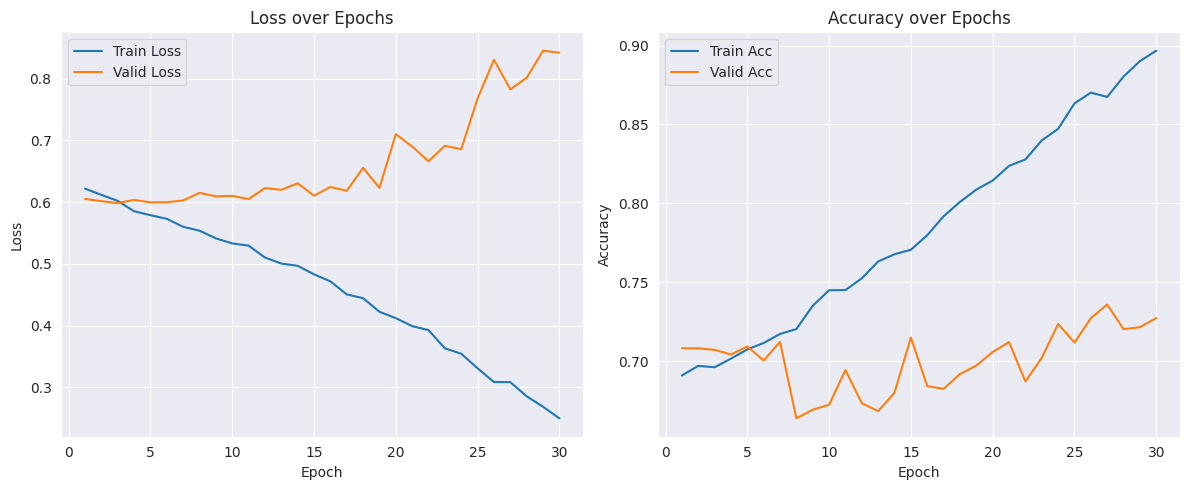

In [26]:
# Visualization
sns.set_style("darkgrid")
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, N_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, N_EPOCHS + 1), valid_losses, label='Valid Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, N_EPOCHS + 1), train_accuracies, label='Train Acc')
plt.plot(range(1, N_EPOCHS + 1), valid_accuracies, label='Valid Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


Evaluate on Test Data
Load the best model and evaluate its performance on the test dataset.

In [27]:
# Load the best model
model.load_state_dict(torch.load('best-model.pt'))

# Evaluate on test data
test_loss, test_acc = eval_fn(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc * 100:.2f}%")


<ipython-input-27-66bdd5dec92d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best-model.pt'))


Test Loss: 0.7719 | Test Accuracy: 50.72%


**Confusion Matrix**

Generate a confusion matrix to visualize the performance of the model on the test set.

Predicting: 100%|██████████| 79/79 [00:21<00:00,  3.61it/s]


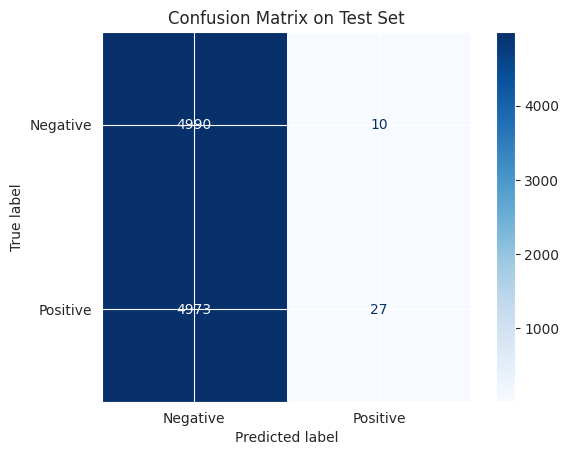

In [28]:
# Function to get predictions and labels
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, lengths, labels in tqdm(loader, desc='Predicting'):
            texts, lengths = texts.to(device), lengths.to(device)
            predictions = torch.sigmoid(model(texts, lengths))
            preds = torch.round(predictions)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return all_preds, all_labels

# Get predictions and labels
test_preds, test_labels = get_predictions(model, test_loader, device)

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Set')
plt.show()


**Predict on Custom Sentences**

Use the trained model to predict the sentiment of custom movie reviews.

In [29]:
# Function to predict sentiment of a single sentence
def predict_sentiment(model, text, stoi, nlp, device, max_length=256):
    model.eval()
    tokens = tokenize(text, nlp)
    numericalized = [stoi.get(t, stoi['<unk>']) for t in tokens]
    if len(numericalized) > max_length:
        numericalized = numericalized[:max_length]
    lengths = torch.tensor([len(numericalized)], dtype=torch.long).to(device)
    tensor = torch.tensor(numericalized, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = torch.sigmoid(model(tensor, lengths))
    return prediction.item()

# Sample reviews
sample_reviews = [
    "This movie was absolutely fantastic, I loved it!",
    "I hated this movie, it was so bad and boring.",
    "It was okay, not great but not terrible either.",
]

# Predict and display results
for review in sample_reviews:
    score = predict_sentiment(model, review, stoi, nlp, device)
    sentiment = "Positive" if score >= 0.5 else "Negative"
    print(f"Review: {review}\nPredicted: {sentiment} (Score: {score:.4f})\n")


Review: This movie was absolutely fantastic, I loved it!
Predicted: Negative (Score: 0.2000)

Review: I hated this movie, it was so bad and boring.
Predicted: Negative (Score: 0.1177)

Review: It was okay, not great but not terrible either.
Predicted: Negative (Score: 0.2840)

